
# Validation of the simulation environment

### Change with previous version
The purpose of this exercise is to replicate the polarization curves, now using the version 1.0 of Gass' repository.

## Purpose
In this exercise, our goal is to replicate Figure 3.2 from Raphaël Gass's thesis manuscript, which shows a polarization curve for a Proton Exchange Membrane (PEM) fuel cell at a pressure of 1.5 bar. We will use the AlphaPEM model to simulate this curve under the specified conditions. This will help us verify the simulation environment and ensure that our model is correctly set up. 

Figure 3.2 in the thesis manuscript presents a polarization curve, which illustrates how the cell voltage varies with current density, for a PEM fuel cell operating at a pressure of 1.5 bar. 

## Simulation conditions
Here are the sources for the simulation conditions used for Fig. 3.2:

1. Operating Conditions: Table 3.3 (Manufacturer operating conditions).
2. Physical Parameters: Table 3.2 (Accessible physical parameters).
3. Undetermined Physical Parameters: Table 3.4 (Calibrated undetermined parameters).
4. Pressure: Figure 3.2 caption and description.

In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt

In [2]:
sys.path.append(os.path.abspath("../external/AlphaPEM_v1.0/"))

from configuration.settings import current_density_parameters, physical_parameters, computing_parameters, operating_inputs
from configuration.current_densities import polarization_current
from model.AlphaPEM import AlphaPEM

Define the experimental conditions for Figure 3.2

In [3]:
# Operating conditions
my_operating_conditions = {
    "Tfc": 347.15,       # Important: In Kelvin. In GUI, °C are used
    "Pa_des": 1.5e5,       # Important: Converted from bar to pascal (1 bar = 10**5 Pa)
    "Pc_des": 1.5e5,
    "Sa": 1.2,
    "Sc": 2.0,
    "Phi_a_des": 0.4,
    "Phi_c_des": 0.6,
}

# Accessible Physical Parameters
my_accessible_physical_parameters = {
    "Aact": 8.5e-3,  # Note: Here, in m^2. In GUI, in cm^2
    "Hmem": 2e-5,
    "Hcl": 1e-5,
    "Hgdl": 2e-4,
    "Hgc": 5e-4,
    "Wgc": 4.5e-4,
    "Lgc": 9.67,
}

# Undetermined Physical Parameters
my_undetermined_physical_parameters = {
    "i0_c_ref": 2.79,
    "kappa_co": 27.2,
    "kappa_c": 1.61,
    "tau": 1.016,                 # Changed to match GUI (from 1.02 to 1.016)
    "epsilon_mc": 0.399,
    "Re": 5.70e-7,
    "e": 5,
    "epsilon_c": 0.271,
    "epsilon_gdl": 0.701,
    "a_slim": 0.05553,           # Changed to match the GUI (went from 0.056 to 0.05553)
    "b_slim": 0.10514,           # Added some decimal digits (from 0.105 to 0.10514) to match GUI
    "a_switch": 0.63654,         # Changed to match GUI (from 0.637 to 0.63654)
    "C_scl": 2e7,   # Default value at page 145
}


In [4]:
# Current Density Parameters
type_current = "polarization"
t_step, i_step, delta_pola, i_EIS, ratio_EIS, f_EIS, t_EIS, current_density = current_density_parameters(type_current)

my_current_density_parameters = {
    "t_step": t_step,
    "i_step": i_step,
    "delta_pola": delta_pola,
    "i_EIS": i_EIS,
    "ratio_EIS": ratio_EIS,
    "t_EIS": t_EIS,
    "f_EIS": f_EIS,
    "current_density": current_density,
    "i_max_pola": 3e4,   # Important: in A/m^2 -> keep consistent with i_step
}

print("Current Density Parameters:")
print("t_step:", t_step)
print("i_step:", i_step)
print("delta_pola:", delta_pola)

Current Density Parameters:
t_step: (0, 1000, 50, 10)
i_step: (5000.0, 15000.0)
delta_pola: (30, 30, 1000.0, 60)


In [5]:
# Computing Parameters
max_step, n_gdl, t_purge = computing_parameters(type_current, my_accessible_physical_parameters["Hgdl"], my_accessible_physical_parameters["Hcl"])

my_computing_parameters = {
    "max_step": max_step,
    "n_gdl": n_gdl,
    "t_purge": t_purge,
}

print("Computing parameters:")
print("max_step:", max_step)
print("n_gdl:", n_gdl)
print("t_purge:", t_purge)

Computing parameters:
max_step: 0.1
n_gdl: 10
t_purge: (0.6, 15)


In [6]:
# Model Possibilities
my_model_possibilities = {
    "type_fuel_cell": "manual_setup",    # Changed to match GUI. Before: "manual_setup",  Now: "EH-31_1.5"
    "type_current": type_current,
    "type_auxiliary":  "forced-convective_cathode_with_flow-through_anode",      #Changed from "no_auxiliary" to "forced-convective_cathode_with_flow-through_anode" to match GUI
    "type_control": "no_control",
    "type_purge": "no_purge",
    "type_display": "no_display",  # Originally: "no_display". Changed to "synthetic" to match GUI
    "type_plot": "fixed"
}

In [7]:
simulation_parameters = {
    **my_operating_conditions,
    **my_accessible_physical_parameters,
    **my_undetermined_physical_parameters,
    **my_current_density_parameters,
    **my_computing_parameters,
    **my_model_possibilities,
}

simulator = AlphaPEM(**simulation_parameters)

In [8]:
variables, operating_inputs, parameters = simulator.variables, simulator.operating_inputs, simulator.parameters

t = np.array(variables['t'])
Ucell_t = np.array(variables['Ucell'])
current_density = operating_inputs['current_density']
t_step, i_step, i_max_pola = parameters['t_step'], parameters['i_step'], parameters['i_max_pola']
delta_pola = parameters['delta_pola']

if parameters['type_plot'] == "fixed":
    n = len(t)
    ifc_t = np.zeros(n)
    for j in range(n):
        ifc_t[j] = current_density(t[j], parameters) / 1e4  # Convert A/m² to A/cm²

    delta_t_load_pola, delta_t_break_pola, delta_i_pola, delta_t_ini_pola = delta_pola
    nb_loads = int(i_max_pola / delta_i_pola + 1)
    ifc_discretized = np.zeros(nb_loads)
    Ucell_discretized = np.zeros(nb_loads)

    for k in range(nb_loads):
        t_load = delta_t_ini_pola + (k + 1) * (delta_t_load_pola + delta_t_break_pola) - delta_t_break_pola / 10
        idx = (np.abs(t - t_load)).argmin()
        ifc_discretized[k] = ifc_t[idx]
        Ucell_discretized[k] = Ucell_t[idx]


polarization_curve_df = pd.DataFrame({
    "Current Density (A/cm²)": ifc_discretized,
    "Cell Voltage (V)": Ucell_discretized
})

print("Number of data points:", len(polarization_curve_df))

Number of data points: 31


Load the data from two sources: Figure 3.2 from the manuscript and GUI EH-31 with 1.5 bar for anode and cathode pressure.

In [16]:
manuscript_data_path = "../data/external/fig3.2_blue_1.5_pressure.csv"
gui_data_path = "../data/external/version1.0/fig3.2_fromGUI_1.5_pressure_v1.0.csv"

manuscript_data = pd.read_csv(manuscript_data_path, delimiter=';', decimal = ",", names=[ "Current Density (A/cm²)", "Cell Voltage (V)"])
gui_data = pd.read_csv(gui_data_path, delimiter=';', decimal = ",", names=["Current Density (A/cm²)", "Cell Voltage (V)"])

manuscript_data = manuscript_data.sort_values(by="Current Density (A/cm²)")  # Sort the data by current density (X-axis)
gui_data = gui_data.sort_values(by="Current Density (A/cm²)")

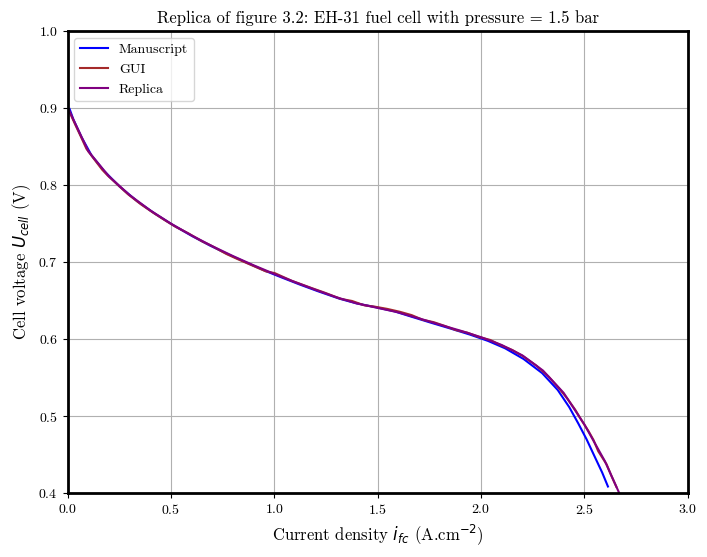

In [17]:
free_y_limit = False

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(manuscript_data["Current Density (A/cm²)"], manuscript_data["Cell Voltage (V)"], label='Manuscript', color='blue', linestyle='-')
ax.plot(gui_data["Current Density (A/cm²)"], gui_data["Cell Voltage (V)"], label='GUI', color='brown', linestyle='-')
ax.plot(polarization_curve_df["Current Density (A/cm²)"], polarization_curve_df["Cell Voltage (V)"], label='Replica', color='purple', linestyle='-')

ax.set_title("Replica of figure 3.2: EH-31 fuel cell with pressure = 1.5 bar")
ax.set_xlabel('Current density $i_{fc}$ (A.cm$^{-2}$)', fontsize=12)
ax.set_ylabel('Cell voltage $U_{cell}$ (V)', fontsize=12)

ax.legend(loc='upper left', fontsize=10)
ax.grid(True)

ax.set_xlim(0, 3)
if free_y_limit == False: 
    ax.set_ylim(0.4, 1.0)  # Matching those of figure 3.2 from manuscript

plt.show()


### Conclusions

In order to obtain the same polarization plot as the GUI, some of the parameters had to be adjusted. Here are the changes made to the parameters:

| Type of Parameter       | Name (in code)               | Previous Value | New Value      |
|-------------------------|--------------------------------|-----------------|----------------|
| Undetermined Physical  | tau                           | 1.02            | 1.016          |
| Undetermined Physical  | a_slim                        | 0.056           | 0.05553        |
| Undetermined Physical  | b_slim                        | 0.105           | 0.10514        |
| Undetermined Physical  | a_switch                      | 0.637           | 0.63654        |
| Model Possibilities     | type_fuel_cell                | manual_setup    | EH-31_1.5      |
| Model Possibilities     | type_auxiliary                | no_auxiliary    | forced-convective_cathode_with_flow-through_anode |
| Model Possibilities     | type_display                 | no_display      | synthetic      |

Note: At least from visual inspection, the parameter that had the most significant impact was the type_auxiliary. This parameter and its possible values need to be studied, so that we can understand why setting it to "no_auxiliary" leads to negative voltage values*. 

*) Could this be the reason we are getting negative results in the other samples?

On the other hand, there is a clear difference between the polarization curves from the manuscript and those who were reproduced here. The reason is still unknown to me, since all the parameters match the values presented in the manuscript. I saw that Gass made some updates to the repository since the publication of the thesis and paper, so this is perhaps why?

## Replication of figure 3.1: Pressure of 2.0, 2.25 and 2.5 bar for a EH-31 fuel cell

We will now try to reproduce the polarization curves presented in the figure 3.1 of the thesis manuscript. These share the same experimental conditions that figure 3.2 has, except for the pressure of anode and cathode (which is here set to 2, 2.25 or 2.5 bar).

In [18]:
def simulate_and_plot(pressure, manuscript_data_path, gui_data_path=None, free_y_lim = True):
    # Define the experimental conditions (all parameters)

    # Operating conditions
    my_operating_conditions = {
        "Tfc": 347.15,       # Important: In Kelvin. In GUI, °C are used
        "Pa_des": pressure,  
        "Pc_des": pressure,
        "Sa": 1.2,
        "Sc": 2.0,
        "Phi_a_des": 0.4,
        "Phi_c_des": 0.6,
    }

    # Accessible Physical Parameters
    my_accessible_physical_parameters = {
        "Aact": 8.5e-3,  # Note: Here, in m^2. In GUI, in cm^2
        "Hmem": 2e-5,
        "Hcl": 1e-5,
        "Hgdl": 2e-4,
        "Hgc": 5e-4,
        "Wgc": 4.5e-4,
        "Lgc": 9.67,
    }

    # Undetermined Physical Parameters
    my_undetermined_physical_parameters = {
        "i0_c_ref": 2.79,
        "kappa_co": 27.2,
        "kappa_c": 1.61,
        "tau": 1.016,                 # Changed to match GUI (from 1.02 to 1.016)
        "epsilon_mc": 0.399,
        "Re": 5.70e-7,
        "e": 5,
        "epsilon_c": 0.271,
        "epsilon_gdl": 0.701,
        "a_slim": 0.05553,           # Changed to match the GUI (went from 0.056 to 0.05553)
        "b_slim": 0.10514,           # Added some decimal digits (from 0.105 to 0.10514) to match GUI
        "a_switch": 0.63654,         # Changed to match GUI (from 0.637 to 0.63654)
        "C_scl": 2e7,   # Default value at page 145
    }

    # Current Density Parameters
    type_current = "polarization"
    t_step, i_step, delta_pola, i_EIS, ratio_EIS, f_EIS, t_EIS, current_density = current_density_parameters(type_current)

    my_current_density_parameters = {
        "t_step": t_step,
        "i_step": i_step,
        "delta_pola": delta_pola,
        "i_EIS": i_EIS,
        "ratio_EIS": ratio_EIS,
        "t_EIS": t_EIS,
        "f_EIS": f_EIS,
        "current_density": current_density,
        "i_max_pola": 3e4,   # Important: in A/m^2 -> keep consistent with i_step
    }

    # Computing Parameters
    max_step, n_gdl, t_purge = computing_parameters(type_current, my_accessible_physical_parameters["Hgdl"], my_accessible_physical_parameters["Hcl"])

    my_computing_parameters = {
        "max_step": max_step,
        "n_gdl": n_gdl,
        "t_purge": t_purge,
    }

    # Model Possibilities
    my_model_possibilities = {
        "type_fuel_cell": "manual_setup",    # Changed to match GUI. Before: "manual_setup",  Now: "EH-31_1.5"
        "type_current": type_current,
        "type_auxiliary": "forced-convective_cathode_with_flow-through_anode",      #Changed from "no_auxiliary" to "forced-convective_cathode_with_flow-through_anode" to match GUI
        "type_control": "no_control",
        "type_purge": "no_purge",
        "type_display": "synthetic",  # Originally: "no_display". Changed to "synthetic" to match GUI
        "type_plot": "fixed"
    }

    simulation_parameters = {
        **my_operating_conditions,
        **my_accessible_physical_parameters,
        **my_undetermined_physical_parameters,
        **my_current_density_parameters,
        **my_computing_parameters,
        **my_model_possibilities,
    }

    print("Running the simulation...")
    simulator = AlphaPEM(**simulation_parameters)

    variables, operating_inputs, parameters = simulator.variables, simulator.operating_inputs, simulator.parameters

    t = np.array(variables['t'])
    Ucell_t = np.array(variables['Ucell'])
    current_density = operating_inputs['current_density']
    t_step, i_step, i_max_pola = parameters['t_step'], parameters['i_step'], parameters['i_max_pola']
    delta_pola = parameters['delta_pola']

    if parameters['type_plot'] == "fixed":
        n = len(t)
        ifc_t = np.zeros(n)
        for j in range(n):
            ifc_t[j] = current_density(t[j], parameters) / 1e4  # Convert A/m² to A/cm²

        delta_t_load_pola, delta_t_break_pola, delta_i_pola, delta_t_ini_pola = delta_pola
        nb_loads = int(i_max_pola / delta_i_pola + 1)
        ifc_discretized = np.zeros(nb_loads)
        Ucell_discretized = np.zeros(nb_loads)

        for k in range(nb_loads):
            t_load = delta_t_ini_pola + (k + 1) * (delta_t_load_pola + delta_t_break_pola) - delta_t_break_pola / 10
            idx = (np.abs(t - t_load)).argmin()
            ifc_discretized[k] = ifc_t[idx]
            Ucell_discretized[k] = Ucell_t[idx]

    polarization_curve_df = pd.DataFrame({
        "Current Density (A/cm²)": ifc_discretized,
        "Cell Voltage (V)": Ucell_discretized
    })

    print("Number of data points from the simulation:", len(polarization_curve_df))

    # Load the data from two sources: Figure 3.2 from the manuscript and GUI EH-31 with 1.5 bar for anode and cathode pressure.
    manuscript_data = pd.read_csv(manuscript_data_path, delimiter=';', decimal=",", names=["Current Density (A/cm²)", "Cell Voltage (V)"])
    manuscript_data = manuscript_data.sort_values(by="Current Density (A/cm²)")  # Sort the data by current density (X-axis)

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(manuscript_data["Current Density (A/cm²)"], manuscript_data["Cell Voltage (V)"], label='Manuscript', color='blue', linestyle='-')
    if gui_data_path:
        gui_data = pd.read_csv(gui_data_path, delimiter=';', decimal=",", names=["Current Density (A/cm²)", "Cell Voltage (V)"])
        gui_data = gui_data.sort_values(by="Current Density (A/cm²)")
        ax.plot(gui_data["Current Density (A/cm²)"], gui_data["Cell Voltage (V)"], label='GUI', color='brown', linestyle='-')
    ax.plot(polarization_curve_df["Current Density (A/cm²)"], polarization_curve_df["Cell Voltage (V)"], label='Replica', color='green', linestyle='-')

    ax.set_title(f"Replica of figure 3.2: EH-31 fuel cell with pressure = {pressure/1e5} bar")
    ax.set_xlabel('Current density $i_{fc}$ (A.cm$^{-2}$)', fontsize=12)
    ax.set_ylabel('Cell voltage $U_{cell}$ (V)', fontsize=12)

    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True)

    ax.set_xlim(0, 3)
    if free_y_lim == False:
        ax.set_ylim(0.4, 1.0)  # Matching those of figure 3.2 from manuscript

    plt.show()


Running the simulation...
Number of data points from the simulation: 31


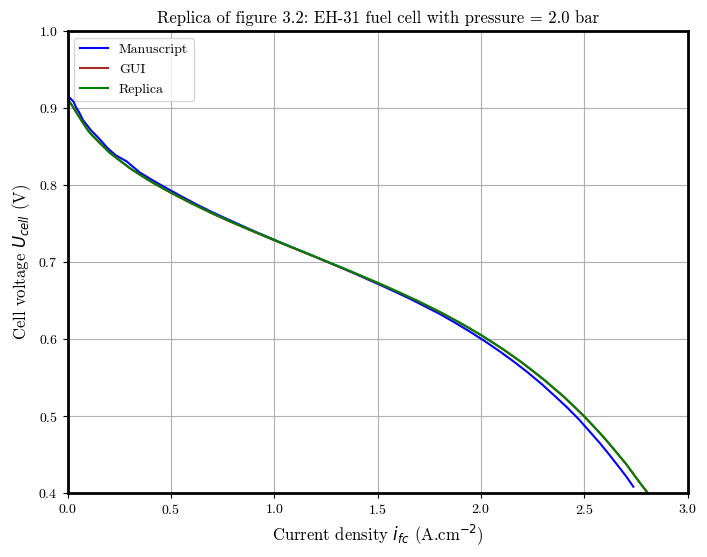

In [20]:
pressure = 2.0e5  # 2.0 bar
manuscript_data_path = "../data/external/fig3.1_orange_2.0_pressure.csv"
gui_data_path = "../data/external/version1.0/fig3.1_fromGUI_2.0_pressure_v1.0.csv"
simulate_and_plot(pressure, manuscript_data_path, gui_data_path, free_y_lim=False)

Running the simulation...
Number of data points from the simulation: 31


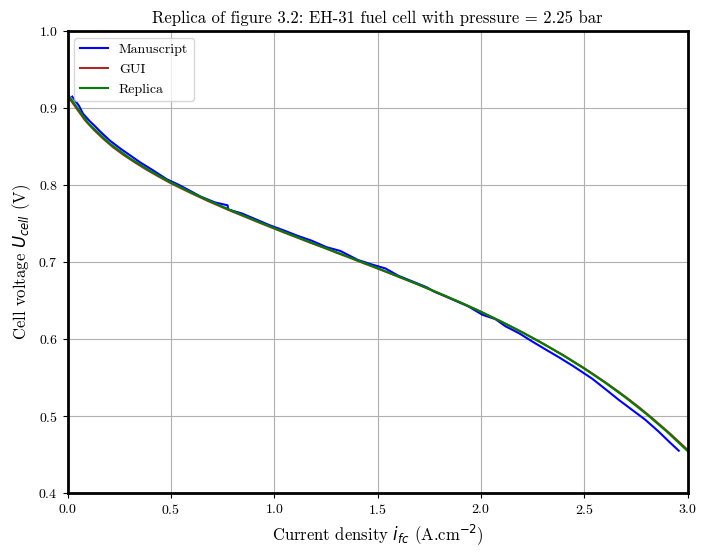

In [21]:
pressure = 2.25e5  # 2.25 bar
manuscript_data_path = "../data/external/fig3.1_green_2.25_pressure.csv"
gui_data_path = "../data/external/version1.0/fig3.1_fromGUI_2.25_pressure_v1.0.csv"

simulate_and_plot(pressure, manuscript_data_path, gui_data_path, free_y_lim=False)

Running the simulation...
Number of data points from the simulation: 31


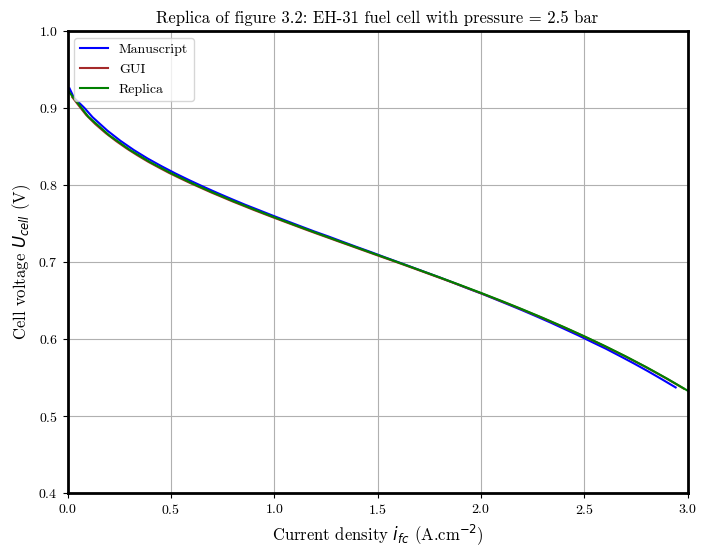

In [22]:
pressure = 2.5e5  # 2.5 bar
manuscript_data_path = "../data/external/fig3.1_red_2.5_pressure.csv"
gui_data_path = "../data/external/version1.0/fig3.1_fromGUI_2.5_pressure_v1.0.csv"
simulate_and_plot(pressure, manuscript_data_path, gui_data_path, free_y_lim = False)